# Compare lithium-ion battery models

We compare three one-dimensional lithium-ion battery models: [the Doyle-Fuller-Newman (DFN) model](./DFN.ipynb), [the single particle model (SPM)](./SPM.ipynb), and [the single particle model with electrolyte (SPMe)](./SPMe.ipynb). Further details on these models can be found in [[1]](#ref).

<a name="ref">[1]</a> Scott G. Marquis, Valentin Sulzer, Robert Timms, Colin P. Please, and S. Jon Chapman. "An asymptotic derivation of a single particle model with electrolyte." arXiv preprint arXiv:1905.12553 (2019).


## Key steps:

Comparing models consists of 6 easy steps:

 1. Load models and geometry
 2. Process parameters
 3. Mesh the geometry
 4. Discretise models 
 5. Solve models
 6. Plot results 

But, as always we first import pybamm and other required modules

In [1]:
import pybamm
import os
os.chdir(pybamm.__path__[0]+'/..')

import numpy as np
import matplotlib.pyplot as plt

## 1. Load models

Since the three models we want to compare are already implemented in PyBaMM, they can be easy loaded using: 

In [2]:
dfn = pybamm.lithium_ion.DFN()
spme = pybamm.lithium_ion.SPMe()
spm = pybamm.lithium_ion.SPM()

To allow us to perform the same operations on each model easily, we create a dictionary of these three models:

In [3]:
models = {"DFN": dfn, "SPM": spm, "SPMe": spme}

Each model can then be accessed using:

In [4]:
models["DFN"]

For each model, we must also provide a cell geometry. The geometry is different for different models; for example, the SPM has solves for a single particle in each electrode whereas the DFN solves for many particles. For simplicity, we use the default geometry associated with each model but note that this can be easily changed.

In [5]:
geometry = {"DFN": dfn.default_geometry, "SPM": spm.default_geometry, "SPMe": spme.default_geometry}

## 2. Process parameters

For simplicity, we use the default parameters values associated with the DFN model, but change the current function to be an input so that we can quickly solve the model with different currents

In [6]:
param = dfn.default_parameter_values

def current_function(t):
    return pybamm.InputParameter("current")

param["Current function [A]"] = current_function

It is simple to change this to a different parameter set if desired. 

We then process the parameters in each of the models and geometries using this parameter set:

In [7]:
for model_name in models.keys():
    param.process_model(models[model_name])
    param.process_geometry(geometry[model_name])

## 3. Mesh geometry

We use the defaults mesh properties (the types of meshes and number of points to be used) for simplicity to generate a mesh of each model geometry. We store these meshes in a dictionary of similar structure to the geometry and models dictionaries:

In [8]:
mesh = {}
for model_name, model in models.items():
    mesh[model_name] = pybamm.Mesh(geometry[model_name], model.default_submesh_types, model.default_var_pts)

## 4. Discretise model

We now discretise each model using its associated mesh and the default spatial method associated with the model:

In [9]:
for model_name, model in models.items():
    disc = pybamm.Discretisation(mesh[model_name], model.default_spatial_methods)
    disc.process_model(model)

## 5. Solve model

We now solve each model using the default solver associated with each model:

In [10]:
timer = pybamm.Timer()
solutions = {}
t_eval = np.linspace(0, 0.15, 300)
solver = pybamm.CasadiSolver()
for model_name, model in models.items():
    start = timer.time()
    solution = solver.solve(model, t_eval, inputs={"current": 1})
    end = timer.time()
    print("Solved the {} in {:.3f} seconds".format(model.name, end-start))
    solutions[model_name] = solution

Solved the Doyle-Fuller-Newman model in 2.111 seconds
Solved the Single Particle Model in 0.386 seconds
Solved the Single Particle Model with electrolyte in 0.399 seconds


## 6. Plot results

To plot results, we extract the variables from the solutions dictionary. Matplotlib can then be used to plot the voltage predictions of each models as follows:

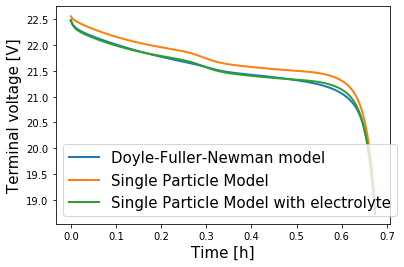

In [11]:
for model_name, model in models.items():
    t = solutions[model_name].t
    time = solutions[model_name]["Time [h]"](t)
    voltage = solutions[model_name]["Terminal voltage [V]"](t)
    plt.plot(time, voltage * 6, lw=2, label=model.name)
plt.xlabel("Time [h]", fontsize=15)
plt.ylabel("Terminal voltage [V]", fontsize=15)
plt.legend(fontsize=15)
plt.show()

Alternatively the inbuilt `QuickPlot` functionality can be employed to compare a set of variables over the discharge. We must first create a list of the models and a list of the solutions (instead of disctionary)

In [12]:
list_of_models = [models[name] for name in models.keys()]
list_of_solutions = [solutions[name] for name in models.keys()]
a_mesh = list(mesh.values())[0]

And then employ `QuickPlot`:

In [13]:
quick_plot = pybamm.QuickPlot(list_of_solutions)
import ipywidgets as widgets
widgets.interact(quick_plot.plot, t=widgets.FloatSlider(min=0,max=quick_plot.max_t,step=0.05,value=0));

interactive(children=(FloatSlider(value=0.0, description='t', max=0.673927318840113, step=0.05), Output()), _d…

# A note on changing parameters:

Since we have made current an input, it is easy to change it and then perform the calculations again:

In [14]:
# update parameter values and solve again
for model_name, model in models.items():
    solutions[model_name] = model.default_solver.solve(model, t_eval, inputs={"current": 5})

# Plot
list_of_models = list(models.values())
list_of_solutions = list(solutions.values())

quick_plot = pybamm.QuickPlot(list_of_solutions)
widgets.interact(quick_plot.plot, t=widgets.FloatSlider(min=0,max=quick_plot.max_t,step=0.05,value=0));

interactive(children=(FloatSlider(value=0.0, description='t', max=0.11652014391160832, step=0.05), Output()), …

By increasing the current, we observe less agreement between the model as expected. 